In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.modules.conv import Conv2d 
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm2d
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self):	
        super(Net, self).__init__()
        self.conv1=Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)#125*125
        
        self.conv2=Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)#61*61
        
        self.conv3=Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2),bias=False)#30*30
        
        self.conv4=Conv2d(256, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)#14*14
        
        self.conv5=Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)#12*12
        
        self.conv6=Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)#10*10
        
        self.conv7=Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)#8*8
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x=self.conv2(x)
        x = F.relu(x)
        
        x=self.conv3(x)
        x = F.relu(x)
        
        x=self.conv4(x)
        x = F.relu(x)
        
        x=self.conv5(x)
        x = F.relu(x)
        
        x=self.conv6(x)
        x = F.relu(x)
                
        x=self.conv7(x)
        return x

In [3]:
model = Net() 
model=model.to(device)
# print(model)

In [4]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness1_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
# data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
# label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [12]:
model=torch.load('models/best_model.pt')

In [13]:
model.to(device)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv7): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
)

In [14]:
label=[]
pre=[]
with torch.no_grad():
    model.eval()
    for j, (inputs, labels) in enumerate(test_loader):
        label.extend(labels.numpy().tolist())
#         label+=labels.numpy()
        inputs = inputs.to(device)
#         labels = labels.to(device)
        outputs = model(inputs)
        pre.extend(outputs.to("cpu").numpy().tolist())
#         pre+=outputs.to("cpu").numpy()



In [15]:
pre=np.squeeze(pre)
label=np.squeeze(label)
np.array(pre).shape

(20, 8, 8)

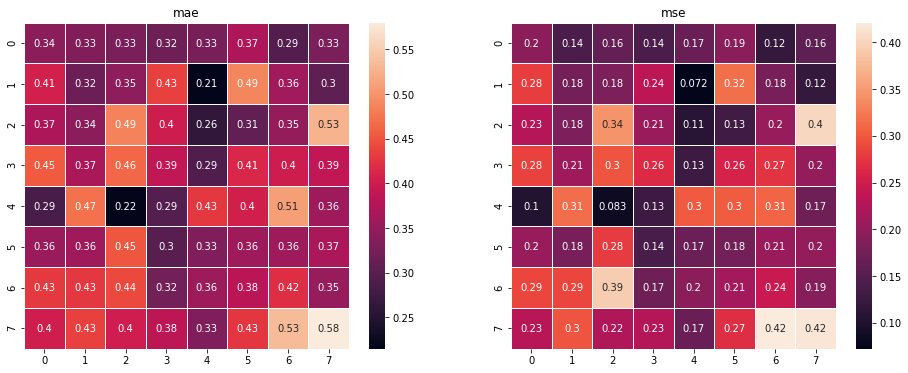

In [16]:
# np.save('label_20.npy',label)
# np.save('pre_20.npy',pre)
mae=np.mean(np.abs(pre-label),axis=0)
mse=np.mean(np.square(pre-label),axis=0)
import seaborn as sns
plt.figure(figsize=(16,6))
ax1 =plt.subplot(121)
ax1.set_title('mae')
h=sns.heatmap(mae, annot=True,linewidths=0.5)  

ax2=plt.subplot(122)
ax2.set_title('mse')
h=sns.heatmap(mse, annot=True,linewidths=0.5)  

# ax1=sns.heatmap(mse, annot=True,linewidths=0.5)  
# fig=ax1.get_figure()
# ax2=sns.heatmap(mse, annot=True,linewidths=0.5)  
# fig=ax1.get_figure()
# plt.legend()
# plt.show()
plt.savefig('../shape1.png')

No handles with labels found to put in legend.


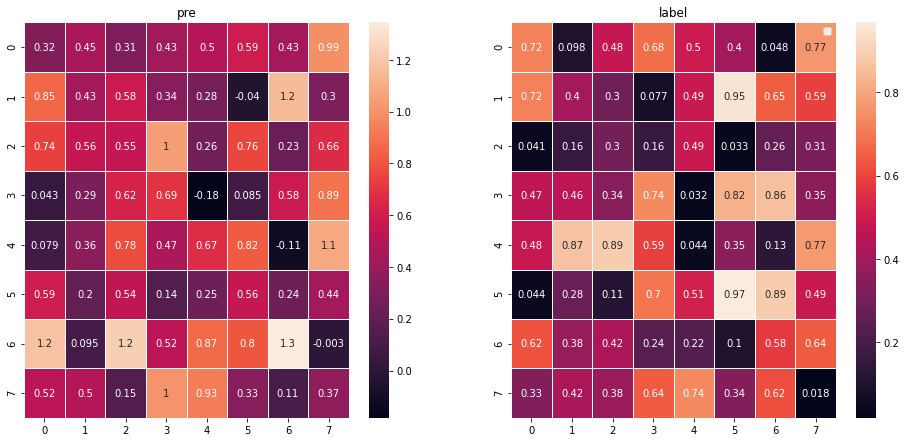

In [17]:

plt.figure(figsize=(16,16))
ax1 =plt.subplot(221)
ax1.set_title('pre')
h=sns.heatmap(pre[0], annot=True,linewidths=0.5)  

ax2=plt.subplot(222)
ax2.set_title('label')
h=sns.heatmap(label[0], annot=True,linewidths=0.5)  

plt.legend()
# plt.show()

# plt.savefig('../shape1.png')

In [18]:
data_max=np.max(label) if np.max(label)>np.max(pre) else np.max(pre)
data_min=np.min(label) if np.min(label)<np.min(pre) else np.min(pre)
print(data_max,data_min)

1.8283547163009644 -0.8719707131385803


No handles with labels found to put in legend.


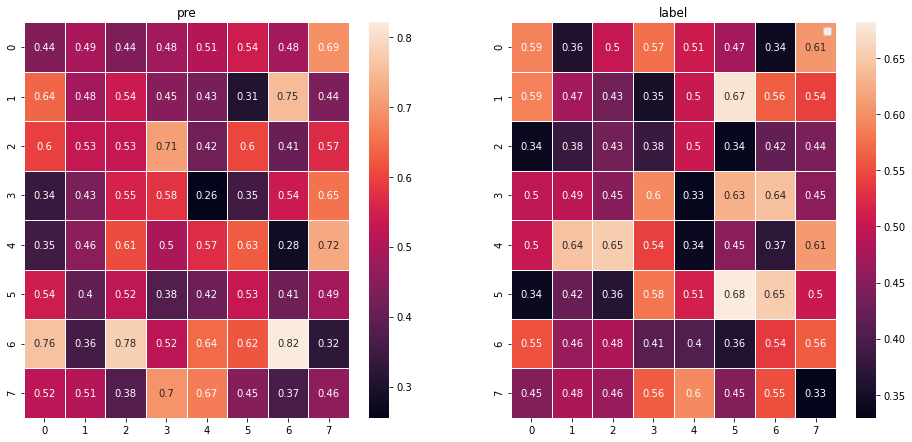

In [19]:
import seaborn as sns
plt.figure(figsize=(16,16))
ax1 =plt.subplot(221)
ax1.set_title('pre')
h=sns.heatmap((pre[0]-data_min)/(data_max-data_min), annot=True,linewidths=0.5)  

ax2=plt.subplot(222)
ax2.set_title('label')
h=sns.heatmap((label[0]-data_min)/(data_max-data_min), annot=True,linewidths=0.5)  

plt.legend()
plt.show()

No handles with labels found to put in legend.


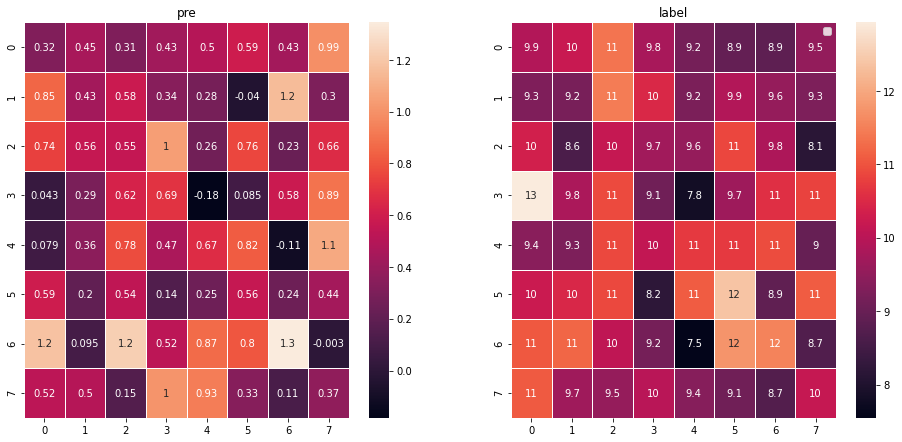

In [20]:
sum=label[0]
for i,la in enumerate(label):
    if not i==0:
        sum+=la
plt.figure(figsize=(16,16))
ax1 =plt.subplot(221)
ax1.set_title('pre')
h=sns.heatmap(pre[0], annot=True,linewidths=0.5)  

ax2=plt.subplot(222)
ax2.set_title('label')
h=sns.heatmap(sum, annot=True,linewidths=0.5)  

plt.legend()
# plt.show()

# plt.savefig('../shape1.png')